In [1]:
import pandas as pd
import os
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

from scipy.signal import argrelextrema

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
base_dir_e = os.path.join('.','data_electrico')
base_dir_c = os.path.join('.','data_combustion')
output_dir_e = os.path.join('.','graphs','electrico')
output_dir_c = os.path.join('.','graphs','combustion')

# Taller 03
## Diego Rodriguez - 201425220

------------
# Tabla de Contenido <a class="anchor" id="toc"></a>

* [Constantes](#Const)
    * [Globales](#Const_G) 
    * [Kart Eléctrico](#Const_E)
    * [Kart de Combustión](#Const_C) 


* [Funciones](#Func)
    * [Importar Datos](#Import_Data) 
    * [Aceleración](#Ac) 
    * [Resistencia a la Rodadura](#Rx) 
    * [Drag](#Drag) 
    * [Torque](#Torque)
    * [Velocidad Angular Motor](#Omega)
    * [Potencia](#Power)
    * [Mapa con Velocidades](#Map_Vel)
    * [Gráficas](#Graph)

    
* [Datos de los Karts](#Data)
    * [Kart de Combustión](#Data_C)
    * [Kart Eléctrico](#Data_E)


* [Análisis](#Analysis)

-------
# Constantes <a class="anchor" id="Const"></a>

### Globales <a class="anchor" id="Const_G"></a>

In [3]:
g = 9.81 # gravedad (m/s2)
rho=1.1955 # densidad del aire (kg/m^3)
u_w=0.0 # velocidad del viento (m/s)
theta=0.0 # ángulo inclinación carretera

### Kart Eléctrico <a class="anchor" id="Const_E"></a>

In [4]:
# Función para contener las constantes del kart eléctrico
def constantes_e():
    # Datos Llantas tractivas 
    rll=0.139 # Radio geométrico de las llantas en traseras (m)
    refc=0.98*rll # Radio efectivo llantas traseras (m)
    rin=0.0631 #radio interno del neumático (m)

    # Datos Transmisión Eléctrico
    dp=10.0 # Dientes del piñón
    dpl=19.0 # Dientes del plato
    ng=dpl/dp # Relación de Transmisión
    etaf=0.95 # Eficiencia de transmisión

    # Datos eje llantas
    reje=0.02 # Radio eje de las llantas (m)
    meje=3.832 # Masa del eje (kg)

    # Datos Kart general
    masa=152.0 # masa del Kart (kg)
    w=masa*g # peso del Kart (N)

    # Datos Fuerzas de la fórmula de aceleración
    dll=0.975 # Distancia entre ejes de llantas delanteras (m)
    alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
    af=(dll*alj)/2 # Area Frontal Kart (m^2)
    cd=0.89 # Coeficiente de Arrastre Kart


    # Inercias
    ii=5.2E-3 # Inercia motor (kg m^2) 

    mllt=1.43 # Masa llantas traseras (kg)
    mlld=1.20 # Masa llantas delanteras (kg)
    rlld=0.129 # Radio llantas delanteras (m)
    rind=0.0631 # Radio rin llantas delanteras (m)
    mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
    mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
    mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
    mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
    illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
    illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

    # Transmisión
    rpi=0.01525 # Radio piñón (m)
    rpla=0.04096 # Radio plato (m)
    rhoac=7850.0 # Densidad del Acero (kg/m^3)
    bpi=0.01 # Ancho piñón (m)
    bpla=0.02 # Ancho plato (m)
    vpi= bpi*np.pi*rpi**2 # Volumen del piñón (m^3)
    vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
    mpi=rhoac*vpi # Masa del piñón (kg)
    mpla=rhoac*vpla # Masa del plato (kg)
    ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

    ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

    mr = ((2*illd + 2*illt)+ieje+((ii+ig)*(ng**2)))/(refc**2) # Masa equivalente de los componentes rotatorios (kg-m^2)

    omega_max = 523.6
    
    # Resistencia a la rodadura     
    a = 0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
    l = 1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
    h = 0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

    return masa, mr, w, refc, ng, etaf, a, l, h, af, cd, omega_max

In [5]:
m_e, mr_e, w_e, refc_e, ng_e, etaf_e, a_e, l_e, h_e, af_e, cd_e, omega_max_e = constantes_e()

### Kart de Combustión <a class="anchor" id="Const_C"></a>

In [6]:
# Función para contener las constantes del kart de combustión
def constantes_c():
    # Datos Llantas tractivas 
    rll=0.139 # Radio geométrico de las llantas en traseras (m)
    refc=0.98*rll # Radio efectivo llantas traseras (m)
    rin=0.0631 #radio interno del neumático (m)

    # Datos Transmisión
    dp=11.0 # Dientes del piñon
    dpl=87.0 # Dientes del plato
    ng=dpl/dp # Relación de Transmisión
    etaf=0.95 # Eficiencia de transmisión

    # Datos eje llantas
    reje=0.02 # Radio eje de las llantas (m)
    meje=3.832 # Masa del eje (kg)

    # Datos Kart general
    masa=140.0 # masa del Kart con piloto(kg)
    w=masa*g # peso del Kart (N)

    # Datos Fuerzas de la fórmula de aceleración
    dll=0.975 # Distancia entre ejes de llantas delanteras (m)
    alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
    af=(dll*alj)/2 # Area Frontal Kart (m^2)
    cd=0.89 # Coeficiente de Arrastre Kart

    # Inercias
    ii=0.01 # Inercia motor de combustión 

    mllt=1.43 # Masa llantas traseras (kg)
    mlld=1.20 # Masa llantas delanteras (kg)
    rlld=0.129 # Radio llantas delanteras (m)
    rind=0.0631 # Radio rin llantas delanteras (m)
    mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
    mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
    mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
    mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
    illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
    illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

    # Transmisión
    rpi=0.01525 # Radio Piñon (m)
    rpla=0.10775 # Radio Plato (m)
    rhoac=7850.0 # Densidad del Acero (kg/m^3)
    bpi=0.01 # Ancho piñon (m)
    bpla=0.01 # Ancho plato (m)
    vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
    vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
    mpi=rhoac*vpi # Masa del piñon (kg)
    mpla=rhoac*vpla # Masa del plato (kg)
    ig=((mpi*(rpi**2))/2)+((mpla*(rpla**2))/2) # Inercia de la transmisión (kg-m^2)

    ieje=(meje*reje**2)/2 # Inercia del eje de las llantas (kg-m^2)

    mr = ((2*illd + 2*illt)+ieje+((ii+ig)*(ng**2)))/(refc**2) # Masa equivalente de los componentes rotatorios (kg-m^2)

    # Resistencia a la rodadura
    a=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
    l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
    h=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)

    return masa, mr, w, refc, ng, etaf, a, l, h, af, cd

In [7]:
m_c, mr_c, w_c, refc_c, ng_c, etaf_c, a_c, l_c, h_c, af_c, cd_c = constantes_c()

[Tabla de Contenido](#toc)

----------
# Funciones <a class="anchor" id="Func"></a>

### Importar Datos <a class="anchor" id="Import_Data"></a>

In [8]:
# Función para importar datos
def import_data (file):
    
    # Nombe del archivo sin extensión
    data_file = file
    
    # Crear la variable de número de líneas para saltar
    start_line = 0               
    
    # Revisar si tiene un '_' en el nombre para saber si es nuevo o viejo
    if '_' in data_file:
        # Asignar la línea donde empiezan los datos
        start_line = 69          
        base_dir = os.path.join('.','data_electrico')
    else:
        start_line = 36
        base_dir = os.path.join('.','data_combustion')

    # Asignar el archivo
    data_vbo = os.path.join(base_dir,data_file+'.VBO')           
    # Importarlo con pandas
    data_pd = pd.read_csv(data_vbo, sep = ' ', header=None, skiprows=start_line)     
    
    # Eliminar la últma columna que siempre está vacía y la primera que es el número de satélites
    if '_' in data_file:
        data_pd.drop(data_pd.columns[[0,14]], axis=1, inplace=True)
        data_pd.columns = ['Time','Lat','Long','Velocity','Heading','Height','Long-Acc','Lat-Acc','Temp','Vbat','batt-flags','batt-ai','batt.soc']
    else:
        data_pd.drop(data_pd.columns[[0,10]], axis=1, inplace=True)
        data_pd.columns = ['Time','Lat','Long','Velocity','Heading','Height','Vert-vel','pot','event-1']
        
    # Convertir la columna de tiempo a String para poder separarlo
    data_pd['Time'] = data_pd['Time'].astype(str)
    
    # Convertir el tiempo a segundos corrigiendo el formato (está hh:mm:ss)
    for i in range(len(data_pd)):
        data_pd.loc[i,('Time')] = float(data_pd.loc[i,('Time')][:2])*3600+float(data_pd.loc[i,('Time')][2:4])*60+float(data_pd.loc[i,('Time')][4:])
        
        # Forma de contar el tiempo que se demora recorriendo el archivo - lee/modifica 530 líneas por segundo
        #if (i % 5300) == 0:
            #print(i/5300)
    
    # Empezar el tiempo en 0.0 segundos
    tiempo_base = data_pd['Time'][0]
    data_pd['Time'] = data_pd['Time'] - tiempo_base
    
    # Dividir latitud y longitud por 60 para pasar de segundos a minutos
    data_pd['Lat'] = data_pd['Lat']/60
    data_pd['Long'] = data_pd['Long']/60
    
    # Dividir la velocidad por 3.6 para pasar de kmh a m/s
    data_pd['Velocity'] = data_pd['Velocity']/3.6
    
    
    return data_pd

### Calcular Aceleración <a class="anchor" id="Acc"></a>

In [9]:
# Función para calcular aceleración
def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

### Resistencia a la Rodadura <a class="anchor" id="Rx"></a>

In [10]:
def frodadura(vx,ax,w,a,l,h):
    
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+((vx*3.6)/100.0)) # Factor de rodadura la velocidad del kart debe estar en (m/s)
    
    Rx = wr*fr*cos(theta) # (N)
    
    return Rx

### Drag <a class="anchor" id="Drag"></a>

In [11]:
def drag(vx, af, cd):
    D = (1.0/2.0)*rho*af*cd*(vx)**2 # (N)
    return D

### Torque Motor <a class="anchor" id="Torque"></a>

In [12]:
def torque(ax, Rx, D, m, mr, ng, etaf, refc): 
    # Sin incluir ángulo de la carretera
    
    T = ((ax*(m+mr)+Rx+D)*refc)/(ng*etaf)
    
    return T

### Velocidad Angular del Motor <a class="anchor" id="Omega"></a>

In [13]:
def rpm_motor(vx,ng,refc):
    
    omega = (vx*ng)/(refc) # (rad/s)
    
    #if elec == True: 
        #for i in range(len(omega)):
            #if omega[i] >= omega_max_e:
                #omega[i] = omega_max_e
    RPM = omega*(60/(2*np.pi))

    return omega, RPM

### Potencia <a class="anchor" id="Power"></a>

In [14]:
def potencia(T,omega):
    
    P = T*omega
    
    return P

### Hacer Mapa con Velocidad <a class="anchor" id="Map_Vel"></a>

In [43]:
def map_speed(vel,lat,long,output_dir): 
    fig, mapa = plt.subplots()

    scaled_z = (vel - vel.min()) / vel.ptp() # Normalizar la velocidad para que vaya de 0 a 1
    colors = plt.cm.spectral(scaled_z) # Crear Colormap

    mapa.scatter(lat,long,edgecolors=colors)
    mapa.plot(lat[0],long[0], 'ok')
    mapa.set_xlim([4.9628,4.9646])
    mapa.set_ylim([73.94931,73.951135])
    mapa.axes.get_xaxis().set_visible(False)
    mapa.axes.get_yaxis().set_visible(False)

    x = pylab.imshow(colors,cmap=cm.spectral) # Crear una imagen para poder crear el colorbar
    cbar = pylab.colorbar(x, ticks=[0, 0.25, 0.5, 0.75, 1]) # Definir las posiciones de 
    cbar.set_label('Velocidad [m/s]')
    cbar.ax.set_yticklabels([int(vel.min()), int(vel.min()+((vel.mean()-vel.min())/2)), 
                             int(vel.mean()), int(vel.mean()+((vel.max()-vel.mean())/2)), int(vel.max())])
    
    #pylab.savefig(os.path.join(output_dir,'Mapa_Velocidad.png'), dpi=200)

### Hacer Gráficas <a class="anchor" id="Graph"></a>

In [47]:
def make_graph(x,y,title,xlabel,ylabel,output_dir,filename):
    pylab.plot(x,y)
    pylab.title(title)
    pylab.xlabel(xlabel)
    pylab.ylabel (ylabel)
    pylab.grid()
    pylab.savefig(os.path.join(output_dir,'{}.png'.format(filename)), dpi=200)

[Tabla de Contenido](#toc)

------------
# Datos <a class="anchor" id="Data"></a>

## Importar Datos Combustión <a class="anchor" id="Data_C"></a>

In [18]:
# Importar datos
datos_c = import_data('VBOX0019')

# Calcular el delta de tiempo para estos datos
dt_c = datos_c['Time'][1]-datos_c['Time'][0]

# Punto de inicio y fin para la vuelta
inicio_c = 13900
fin_c = 19510

# Cortar datos para la vuelta
Time_c = datos_c['Time'][inicio_c:fin_c].values # [s]
Lat_c = datos_c['Lat'][inicio_c:fin_c].values # Latitud
Long_c = datos_c['Long'][inicio_c:fin_c].values # Longitud
Vel_c = datos_c['Velocity'][inicio_c:fin_c].values # [m/s]

# Crear un vector de tiempo sólo para la vuelta y calcular el tiempo de vuelta
lap_time_c = Time_c[-1]-Time_c[0]
t_c = Time_c-Time_c[0]


# Cálculos de las variables restantes
ax_c = accel(Vel_c,dt_c) # Aceleración [m/s2]
omega_c, RPM_c = rpm_motor(Vel_c, ng_c, refc_c) # Velocidad angular del motor [rad/s]
Rx_c = frodadura(Vel_c, ax_c, w_c, a_c, l_c, h_c) # Resistencia a la rodadura [N]
D_c = drag(Vel_c, af_c, cd_c) # Drag [N]
Torque_c = torque(ax_c, Rx_c, D_c, m_c, mr_c, ng_c, etaf_c, refc_c) # Troque Motor [Nm]
Potencia_c = potencia(Torque_c, omega_c)/1000 # Potencia del motor [kW]

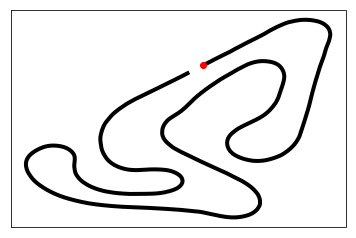

In [85]:
map_c = plt.gca()
map_c.plot(Lat_c[50:],Long_c[50:], 'k',linewidth=4.0)
map_c.plot(Lat_c[0],Long_c[0], 'or')
map_c.axes.get_xaxis().set_visible(False)
map_c.axes.get_yaxis().set_visible(False)
#pylab.savefig(os.path.join(output_dir_c,'Mapa_Combustion.png'), dpi=200)

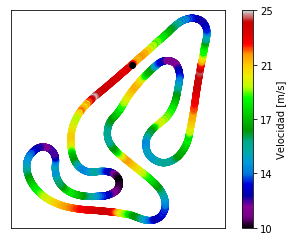

In [45]:
map_speed(Vel_c,Lat_c,Long_c,output_dir_c)

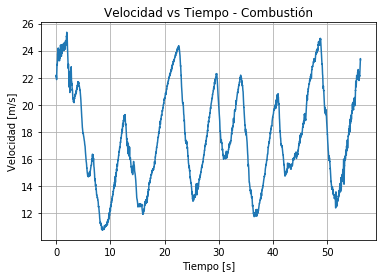

In [58]:
make_graph(t_c,Vel_c,'Velocidad vs Tiempo - Combustión','Tiempo [s]','Velocidad [m/s]',output_dir_c,'Velocidad_C')

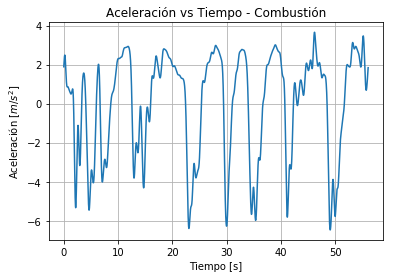

In [63]:
make_graph(t_c,ax_c,'Aceleración vs Tiempo - Combustión','Tiempo [s]','Aceleración [$m/s^2$]',output_dir_c,'Aceleracion_C')

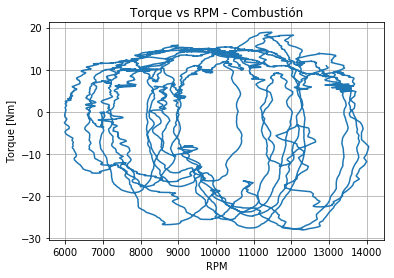

In [64]:
make_graph(RPM_c,Torque_c,'Torque vs RPM - Combustión','RPM','Torque [Nm]',output_dir_c,'Torque_C')

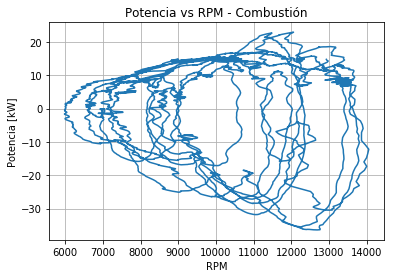

In [65]:
make_graph(RPM_c,Potencia_c,'Potencia vs RPM - Combustión','RPM','Potencia [kW]',output_dir_c,'Potencia_C')

In [76]:
# Calcular Datos
Vmax_c = Vel_c.max()
Vavg_c = Vel_c.mean()
Amax_c = ax_c.max()
Amin_c = ax_c.min()
Aavg_pos_c = np.mean(list(filter(lambda x: x>0, ax_c)))
Aavg_neg_c = np.mean(list(filter(lambda x: x<0, ax_c)))
Tmax_c = Torque_c.max()
Pmax_c = Potencia_c.max()

print("Datos Desempeño Kart de Combustón")
print("\n")
print("El tiempo de vuelta es {0:.2f} s".format(lap_time_c))
print("Velocidad Máxima = {0:.2f} m/s".format(Vmax_c))
print("Velocidad Promedio = {0:.2f} m/s".format(Vavg_c))
print("Aceleración Máxima = {0:.4f} g's".format(Amax_c/g))
print("Desaceleración Máxima = {0:.4f} g's".format(Amin_c/g))
print("Aceleración Promedio = {0:.4f} g's".format(Aavg_pos_c/g))
print("Desaceleración Promedio = {0:.4f} g's".format(Aavg_neg_c/g))
print("Torque Máximo = {0:.3f} Nm".format(Tmax_c))
print("Potencia Máxima = {0:.3f} kW".format(Pmax_c))

Datos Desempeño Kart de Combustón


El tiempo de vuelta es 56.09 s
Velocidad Máxima = 25.36 m/s
Velocidad Promedio = 17.57 m/s
Aceleración Máxima = 0.3727 g's
Desaceleración Máxima = -0.6596 g's
Aceleración Promedio = 0.1884 g's
Desaceleración Promedio = -0.3132 g's
Torque Máximo = 18.890 Nm
Potencia Máxima = 22.938 kW


## Importar Datos Eléctrico <a class="anchor" id="Data_E"></a>

In [54]:
# Importar datos eléctrico
datos_e = import_data('VBS__052')

# Calcular el delta de tiempo para estos datos
dt_e = datos_e['Time'][1]-datos_e['Time'][0]

# Punto de inicio y fin para la vuelta
inicio_e = 6020
fin_e = 9130

# Cortar datos para la vuelta
Time_e = datos_e['Time'][inicio_e:fin_e].values # [s]
Lat_e = datos_e['Lat'][inicio_e:fin_e].values # Latitud
Long_e = datos_e['Long'][inicio_e:fin_e].values # Longitud
Vel_e = datos_e['Velocity'][inicio_e:fin_e].values # [m/s]

# Crear un vector de tiempo sólo para la vuelta y calcular el tiempo de vuelta
lap_time_e = Time_e[-1]-Time_e[0]
t_e = Time_e-Time_e[0]

# Cálculos de las variables restantes
ax_e = accel(Vel_e,dt_e) # Aceleración [m/s2]
omega_e, RPM_e = rpm_motor(Vel_e, ng_e, refc_e) # Velocidad angular del motor [rad/s]
Rx_e = frodadura(Vel_e, ax_e, w_e, a_e, l_e, h_e) # Resistencia a la rodadura [N]
D_e = drag(Vel_e, af_e, cd_e) # Drag [N]
Torque_e = torque(ax_e, Rx_e, D_e, m_e, mr_e, ng_e, etaf_e, refc_e) # Troque Motor [Nm]
Potencia_e = potencia(Torque_e, omega_e)/1000 # Potencia del motor [kW]

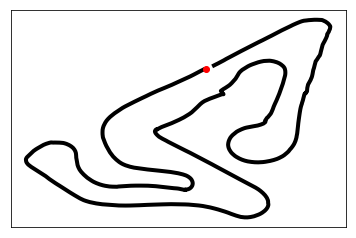

In [151]:
map_c = plt.gca()
map_c.plot(Lat_e[60:],Long_e[60:], 'k',linewidth=4.0)
map_c.plot(Lat_e[0],Long_e[0], 'or')
#map_c.plot(Lat_e[int(2747)],Long_e[int(2747)], 'og')
map_c.axes.get_xaxis().set_visible(False)
map_c.axes.get_yaxis().set_visible(False)
#pylab.savefig(os.path.join(output_dir_e,'Mapa_Electrico.png'), dpi=200)

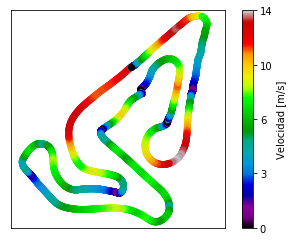

In [56]:
map_speed(Vel_e,Lat_e,Long_e,output_dir_e)

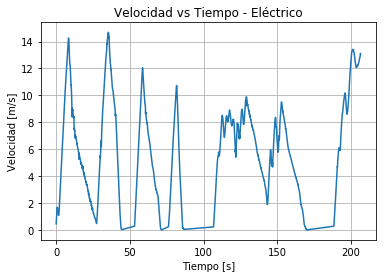

In [66]:
make_graph(t_e,Vel_e,'Velocidad vs Tiempo - Eléctrico','Tiempo [s]','Velocidad [m/s]',output_dir_e,'Velocidad_E')

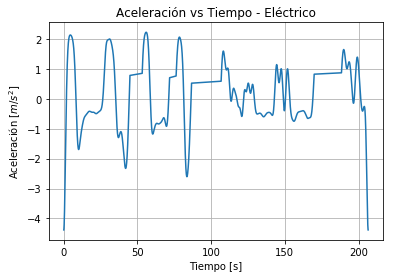

In [68]:
make_graph(t_e,ax_e,'Aceleración vs Tiempo - Eléctrico','Tiempo [s]','Aceleración [$m/s^2$]',output_dir_e,'Aceleracion_E')

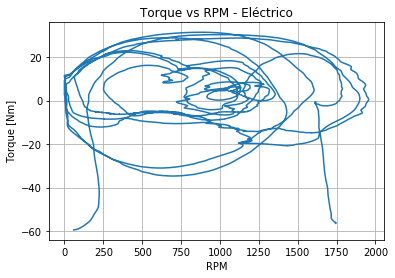

In [69]:
make_graph(RPM_e,Torque_e,'Torque vs RPM - Eléctrico','RPM','Torque [Nm]',output_dir_e,'Torque_E')

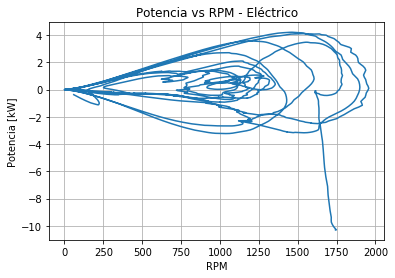

In [70]:
make_graph(RPM_e,Potencia_e,'Potencia vs RPM - Eléctrico','RPM','Potencia [kW]',output_dir_e,'Potencia_E')

In [75]:
# Calcular Datos
Vmax_e = Vel_e.max()
Vavg_e = Vel_e.mean()
Amax_e = ax_e.max()
Amin_e = ax_e.min()
Aavg_pos_e = np.mean(list(filter(lambda x: x>0, ax_e)))
Aavg_neg_e = np.mean(list(filter(lambda x: x<0, ax_e)))
Tmax_e = Torque_e.max()
Pmax_e = Potencia_e.max()

print("Datos Desempeño Kart Eléctrico")
print("\n")
print("El tiempo de vuelta es {0:.2f} s".format(lap_time_e))
print("Velocidad Máxima = {0:.2f} m/s".format(Vmax_e))
print("Velocidad Promedio = {0:.2f} m/s".format(Vavg_e))
print("Aceleración Máxima = {0:.4f} g's".format(Amax_e/g))
print("Desaceleración Máxima = {0:.4f} g's".format(Amin_e/g))
print("Aceleración Promedio = {0:.4f} g's".format(Aavg_pos_e/g))
print("Desaceleración Promedio = {0:.4f} g's".format(Aavg_neg_e/g))
print("Torque Máximo = {0:.3f} Nm".format(Tmax_e))
print("Potencia Máxima = {0:.3f} kW".format(Pmax_e))

Datos Desempeño Kart Eléctrico


El tiempo de vuelta es 206.50 s
Velocidad Máxima = 14.69 m/s
Velocidad Promedio = 6.37 m/s
Aceleración Máxima = 0.2273 g's
Desaceleración Máxima = -0.4470 g's
Aceleración Promedio = 0.1065 g's
Desaceleración Promedio = -0.0805 g's
Torque Máximo = 31.413 Nm
Potencia Máxima = 4.212 kW


[Tabla de Contenido](#toc)

----------
# Análisis <a class="anchor" id="Analysis"></a>

|![Mapa_Vel_New.png](files/graphs/combustion/Mapa_Vel_New.png)|![Mapa_Vel_New.png](files/graphs/electrico/Mapa_Vel_New.png)|
|:---------------------------------------------------------:|:-----------------------------------------------:|
|**Figura 1a**. Mapa del kartódromo de Tocancipá para la vuelta analizada para el kart de combustión. Los colores representan la velocidad a la que iba el kart durante ese momento en la pista. La pista se recorre en sentido anti horario. | **Figura 1b**. Mapa del kartódromo de Tocancipá para la vuelta analizada para el kart eléctrico. Los colores representan la velocidad a la que iba el kart durante ese momento en la pista. La pista se recorre en sentido horario.|

En la Figura 1 se tiene un mapa del kartódromo de Tocancipá obtenido de los datos de latitud y longitud durante cada toma de datos. Superpuesto en el mapa de la pista está la velocidad que cada kart llevaba durante cada punto de la vuelta. De entrada lo primero que se ve es la diferencia en las escalas de velocidad de ambos karts: la del kart de combustión va de 10 a 25 m/s mientras que la del eléctrico va desde 0 hasta tan sólo 14 m/s (50 kmh). 

Mirando de manera más detallada las vueltas de cada kart se pueden hacer más observaciones. Lo primero es que la vuelta del kart de combustión fue lo que se llama un *flying lap*, en donde el kart da una vuelta de calentamiento y pasa a velocidad máxima por la línea de inicio. Esto permite medir una vuelta como si estuviera en carrera. Sin embargo, este no es el caso del kart eléctrico. Se puede ver que antes y después del punto de inicio la diferencia de velocidades es muy alta - esto se debe a que la vuelta registrada por el kart eléctrico empezó con lo que se conoce como un *standing start*, que es cuando el kart se para en la línea de partida y empieza a marcar la vuelta desde ahí. La desventaja de esta vuelta es que el kart pierde mucho tiempo pues no está viajando a su velocidad máxima en la recta principal. La razón por la cual la vuelta es así es porque a la hora de registrar los datos el controlador no estaba bien refrigerado lo que lo llevaba a recalentarse al final de la recta cuando iba a velocidad máxima, y a su vez esto causaba que se apagara el kart. Por eso sólo fue posible registrar una vuelta con *standing start* para evitar que el kart se apagara durante la vuelta. 

Lo segundo que se puede observar es que el kart eléctrico estuvo frenado en áreas en las que no debería estar. Por ejemplo, entre las curvas 1 y 2, justo a la mitad de la recta (en donde el kart de combustión casi llega a su velocidad máxima) el kart eléctrico llega casi a estar estático. Otro punto de estos se ve just después de la curva 2, entre las curvas 3 y 4, justo en la curva 4, y en la entrada a la curva 8. Estos puntos podrían explicarse por el recalentamiento del controlador del motor eléctrico que automáticamente entraba en un modo seguro que cortaba drásticamente la potencia del motor. Sin embargo, esto tendría más sentido si esos puntos fueran al final de una recta - que es donde más se calentaba el controlador. A la salida de una curva - a pesar de la mala refrigeración - no debería estar pasando. Otra razón que podría explicar algunos de estos puntos es la conexión defectuosa de los componentes: por las vibraciones algunas partes del circuito se desconectaban y cortaban la potencia. Este pudo haber sido el caso entre las curvas 3 y 4 en donde el kart estuvo frenado casi 20s (lo cual se puede observar en la Figura 2b). 

Finalmente, otra cosa que llama la atención es la velocidad tan baja a la cual el kart eléctrico tomaba las curvas. El kart de combustión nunca bajo de los $10 m/s$, lo que ocurre en la curva 8. En las curvas 3 y 6 se acerca a los $12 m/s$, y la curva 1 la hace a más o menos $13 m/s$. Si el kart eléctrico hubiese tenido un agarre similar al del kart de combustión hubiera podido mantenerse cerca de su velocidad máxima (y si hubiera estado mejor refrigerado). Sin embargo, el kart eléctrico tomó la curva 8 a $5 m/s$, las curvas 3 y 6 las tomó a $6 m/s$, y en la curva 1 entra frenando cerca de $10 m/s$ pero frena durante la curva y a la salida va sólo a $ 6m/s$. Asumiendo que ambos karts tenían un agarre similar, estas diferencias pueden deberse a que la mala refrigeración del controlador frenaba al kart eléctrico, o a que la dinámica del kart eléctrico no tenía cómodo al piloto y este no tomaba las curvas al máximo que aguantase el kart. 


|![Velocidad_C.png](files/graphs/combustion/Velocidad_C.png)|![Vel_E_New.png](files/graphs/electrico/Vel_E_New.png)|
|:---------------------------------------------------------:|:-----------------------------------------------:|
|**Figura 2a**. Gráfica de velocidad contra tiempo para la vuelta registrada por el kart de gasolina. | **Figura 2b**. Gráfica de velocidad contra tiempo para la vuelta registrada por el kart eléctrico. Las partes resaltadas en rojo representan discontinuidades en los datos. |

Observando la Figura 2 en donde están las gráficas de velocidad contra tiempo se puede corroborar que el kart de combustión empezó su vuelta casi a velocidad máxima mientras que el kart eléctrico la comenzó estando parqueado. 

Sin embargo, lo más interesante son las zonas resaltadas en rojo en la Figura 2b. Estas zonas representan discontinuidades en donde el VBOX dejó de registrar datos repentinamente y unos segundos después volvió a registrar datos. Curiosamente, estas discontinuidades coninciden con partes en donde el kart eléctrico quedó casi estático. El primer mínimo que presenta la Fibura 2b en donde la velocidad se acerca pero no llega a cero corresponde al punto entre las curvas 1 y 2 en donde el kart frenó mucho pero volvió a acelerar. En este caso podría ser por malas conexiones. La primera discontinuidad resaltada en rojo dura 8.3s y corresponde a la salida de la curva 2. La segunda discontinuidad dura 4.4 segundos y corresponde al punto entre las curvas 3 y 4. La tercera discontinuidad dura 20s y corresponde exáctamente a la curva 4 - esta pausa tan larga puede deberse a una falla en el funcionamiento. La última discontinuidad dura 18s y corresponde a la entrada a la curva 8, lo que quiere decir que el kart frenó completamente antes de entrar a esta curva. 

Todas estas caidas en velocidad le impiden al kart mantener una velocidad promedio más alta y llevan a un tiempo de vuelta casi 4 veces mayor que el kart de combustión (lo que se puede observar de los ejes x de en la Figura 2).


|![Aceleracion_C.png](files/graphs/combustion/Aceleracion_C.png)|![Acc_E_New.png](files/graphs/electrico/Acc_E_New.png)|
|:---------------------------------------------------------:|:-----------------------------------------------:|
|**Figura 3a**. Gráfica de aceleración contra tiempo para la vuelta registrada por el kart de gasolina.| **Figura 3b**. Gráfica de aceleración contra tiempo para la vuelta registrada por el kart eléctrico. Las partes resaltadas en rojo representan discontinuidades en los datos. |

La Figura 3 contiene las gráficas de aceleración contra tiempo para ambos karts. En la Figura 3b se pueden observar las mismas discontinuidades de las que se habla con respecto a la Figura 2b. Lo curioso en esta gráfica es que no ocurre cuando la aceleración es cero. Esto es extraño porque en esa zona resaltada de rojo no existe ningún dato, y a pesar de que pasen 20 segundos entre un dato y el otro, el VBOX detecta la misma aceleración antes y después de esos 20 segundos. La distancia no cambia entre estos dos datos, lo que indica que no hubo movimiento.

Aparte de las discontinuidades en los datos del kart, es interesante resaltar la diferencia tan grande en las magnitudes de desaceleración entre ambos karts. La aceleración difiere un poco lo que se podrá detallar en la Tabla 1, pero la desaceleración es mucho mayor para el kart de gasolina que debe frenar de manera más agresiva. 

<h5><center>Tabla 1. Datos de desempeño para ambos karts</center></h5>

||Kart de Combustión|Kart Eléctrico|
|-------:|:----:|:----:|
|Tiempo de Vuelta [s] | 56.09 | 206.50 |
|Velocidad Máxima [$m/s$]| 14.69 | 25.36 |
|Velocidad Promedio [$m/s$]| 6.37 | 17.57 |
|Aceleración Máxima [g's]| 0.2273 | 0.3727 |
|Desaceleración Máxima [g's]| -0.4470 | -0.6596 |
|Aceleración Promedio [g's]| 0.1065 | 0.1884 |
|Desaceleración Promedio [g's]| -0.0805 | -0.3132 |
|Torque Máximo [$Nm$]| 31.413 | 18.890 |
|Potencia Máxima [$kW$]| 4.221 | 22.938 |

En la Tabla 1 se tienen los datos más detallados del desempeño de ambos karts. Lo primero a resaltar es el mal desempeño del kart eléctrico pues registró un tiempo casi 4 veces más grande que el de combustión - debido a bajas velocidades máximas, bajas aceleraciones, y fallas de funcionamiento. 

Las aceleraciones son más cercanas que las desaceleraciones - la aceleración promedio del kart de combustión es 57% mayor que la del eléctrico y la desaceleración promedio es 118% más grande. En general las desaceleraciones son mayores que las aceleraciones, lo que indica que en ambos casos las llantas hubieran aguantado una relación con una aceleración más agresiva. 

En donde el kart eléctrico tiene una ventaja es en el torque del motor, pues se ve que en la vuelta el torque máximo desarrollado por el kart eléctrico (calculado con la inversa de los modelos trabajados en el taller anterior) es 31.4 Nm contra 18.9 Nm del kart de combustión. 

Sin embargo, en términos de potencia el kart eléctrico está muy mal, pues genera 4kW contra 22.9kW del motor de combustión. 

Acá lo más interesante es que los cálculos para el kart eléctrico parecen ser muy precisos ya que el torque máximo de diseño del motor eléctrico es 38Nm y la potencia continua que puede proveer el motor eléctrico es 4.4kW - los datos estuvieron muy cerca. 


|![Torque_C_New.png](files/graphs/combustion/Torque_C_New.png)|![Torque_E_New.png](files/graphs/electrico/Torque_E_New.png)|
|:---------------------------------------------------------:|:-----------------------------------------------:|
|**Figura 4a**. Gráfica del torque del motor de combustión contra las RPM de este. La línea punteada roja marca una tendencia del lado positivo en donde se acumulan muchos datos. | **Figura 4b**. Gráfica del torque del motor eléctrico contra las RPM de este. La línea punteada roja marca una tendencia del lado positivo en donde se acumulan muchos datos. |

Comparando la Figura 4 en donde están los torques contra las RPM de ambos motores es muy claro que el motor de combustión tiene una velocidad de giro muchísimo más alta que la del motor eléctrico - esto posiblemente puede contribuir a la diferencia tan grande en potencias entre ambos karts. Además el kart eléctrico no llegó ni a la mitad de sus RPM máximas.

También es interesante resaltar que entre las líneas punteadas la del kart eléctrico parece ser más constante en el rango medio de RPM's que la del kart de combustión. Esto estaría de acuerdo con la sabiduría general de que un motor eléctrico puede mantener el torque más constante a través de su rango de velocidad angular que un motor de combustión. 

|![Pot_C_New.png](files/graphs/combustion/Pot_C_New.png)|![Pot_E_New.png](files/graphs/electrico/Pot_E_New.png)|
|:---------------------------------------------------------:|:-----------------------------------------------:|
|**Figura 5a**. Gráfica de la potencia del motor de combustión contra las RPM de este. La línea punteada roja marca una tendencia del lado positivo en donde se acumulan muchos datos. | **Figura 5b**. Gráfica de la potencia del motor eléctrico contra las RPM de este. La línea punteada roja marca una tendencia del lado positivo en donde se acumulan muchos datos. |

<h3> Mejoras </h3>

Después de comparar el desempeño de ambos karts - y conociendo de primera mano el estado de desarrollo del kart, y habiendo estado presente en las pruebas - las mejoras principales para el kart eléctrico son en términos de confiabilidad. Es necesario mejorar la calidad de las conexiones para que estas no interrumpan la prueba como ocurrió y como se evidencia en los datos. Lo siguiente es implementar un mejor sistema de refrigeración para el controlador con el fin de que este tampoco interfiera con las pruebas y se pueda hacer una vuelta de tipo *flying lap* para realmente comparar el desempeño del kart eléctrico. 

Por último, teniendo en cuenta los modelos desarrollados en el taller pasado, se recomendaría aumentar la relación actual del kart. En este momento usa una relación de 1.9, la cual (según los modelos) tiene una velocidad máxima de 25 m/s. Sin embargo el kart no se está acercando a eso, por lo cual podría ser conveniente acercar la relación a 3, con lo que tendría una velocidad máxima de $23.7 m/s$ pero se demora sólo 20s hasta esta velocidad y podría hacerlo en sólo 253m. Con la relación actual, según los modelos, necesita 62s para llegar a la velocidad máxima de $25 m/s$ y necesita 1.1 km para hacerlo 